In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler

# import basic libraries 
import h5py
import pandas as pd

from keras.models import Model
from keras.layers import Input, add
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plt.rcParams['figure.dpi'] = 140

2023-06-30 20:42:08.299664: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 20:42:08.545757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
path = "/eos/cms/store/cmst3/group/l1tr/jngadiub/L1TNtupleRun3-ZB-h5-extended-v3/" # where the file is on lxplus
filename = "ZB1_preprocessed.h5"
f = h5py.File(path+filename, 'r')
dataset = f['full_data_cyl']
#Met - 0, electrons - 1,4, muons - 5,8, Jets 9-18

In [45]:
g = h5py.File('/eos/user/t/thaarres/L1TNtupleRun3/Run3_data/chang/BSM_preprocessed.h5', 'r')

In [54]:
dataset_size = 1000000
data_train = dataset[0:dataset_size].astype('float32')
data_valid = dataset[dataset_size:dataset_size+1000].astype('float32') # used for tuning hyper-parameters
data_test = dataset[2*dataset_size:3*dataset_size].astype('float32') # hold out for now

print(data_train.shape,data_test.shape, data_valid.shape)

data_train = data_train.reshape((len(data_train)),np.prod(data_train.shape[1:]))
data_test = data_test.reshape((len(data_test)),np.prod(data_test.shape[1:]))
data_valid = data_valid.reshape((len(data_valid)),np.prod(data_valid.shape[1:]))

print(data_train.shape, data_test.shape, data_valid.shape)

(1000000, 19, 3) (1000000, 19, 3) (1000, 19, 3)
(1000000, 57) (1000000, 57) (1000, 57)


## Constructing the VAE

In [61]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 8

encoder_inputs = keras.Input(shape=(57))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(57,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

Tensor("sampling_17/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_17/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 57)]         0           []                               
                                                                                                  
 normalization_36 (Normalizatio  (None, 57)          0           ['input_37[0][0]']               
 n)                                                                                               
                                                                                                  
 dense_127 (Dense)              (None, 32)           1856        ['normalization_36[0][0]']       
                                                                   

## Training

In [ ]:
#initial_learning_rate = .15
#decay_steps = 20
#lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps) #NOT in use

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=500, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/500
Tensor("encoder/sampling_17/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_17/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling_17/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_17/strided_slice_1:0", shape=(), dtype=int32)
62485/62500 [============================>.] - ETA: 0s - loss: nan - reconstruction_loss: nan - kl_loss: nanTensor("encoder/sampling_17/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_17/strided_slice_1:0", shape=(), dtype=int32)
62500/62500 [==============================] - 212s 3ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan - val_loss: nan - val_reco_loss: nan - val_kl_loss: nan
Epoch 2/500
62500/62500 [==============================] - 205s 3ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan - val_loss: nan - val_reco_loss: nan - val_kl_loss: nan
Epoch 3/500
38736/62500 [=================>............] - ETA: 1:16 - loss: nan - reconstruction_loss: na

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



62500/62500 [==============================] - 206s 3ms/step - loss: nan - reconstruction_loss: nan - kl_loss: nan - val_loss: nan - val_reco_loss: nan - val_kl_loss: nan
Epoch 5/500
31294/62500 [==============>...............] - ETA: 1:42 - loss: nan - reconstruction_loss: nan - kl_loss: nan

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

32/32 [==============================] - 0s 2ms/step


In [30]:
output.shape

(1000, 57)

In [31]:
output

array([[ 1.5413636 ,  0.        ,  0.5729321 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.85794866,  0.        ,  2.8654404 , ...,  0.        ,
         0.        ,  0.        ],
       [20.400942  ,  0.        , -2.4898891 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 9.068504  ,  0.        , -2.7249906 , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.5181255 ,  0.        ,  1.6197536 , ...,  0.        ,
         0.        ,  0.        ],
       [10.849677  ,  0.        ,  2.501524  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [32]:
data_train

array([[10.       ,  0.       , -2.5429688, ...,  0.       ,  0.       ,
         0.       ],
       [10.       ,  0.       , -2.3242188, ...,  0.       ,  0.       ,
         0.       ],
       [ 7.       ,  0.       ,  1.9140625, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [20.       ,  0.       , -2.3242188, ...,  0.       ,  0.       ,
         0.       ],
       [ 4.5      ,  0.       , -2.8027344, ...,  0.       ,  0.       ,
         0.       ],
       [ 9.5      ,  0.       , -0.9760742, ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reco_loss', 'val_kl_loss'])


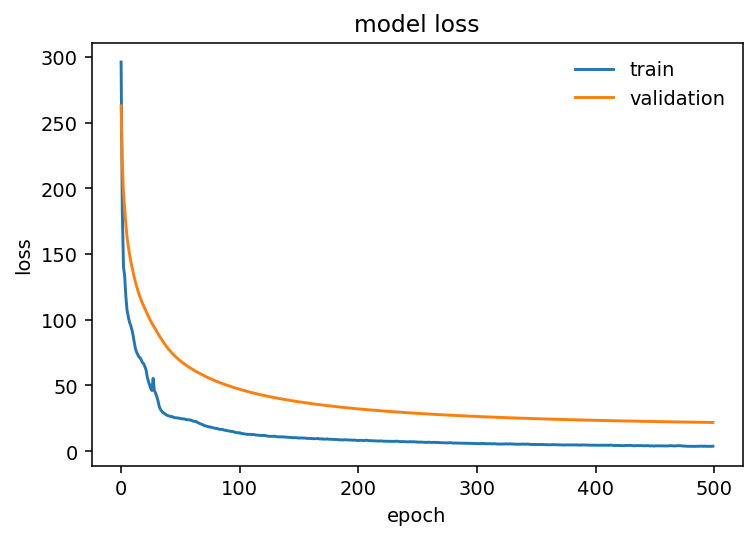

In [33]:
print(history.history.keys())

plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
#plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()

(1000, 19, 3) (1000, 57) (1000, 57)


Text(0.5, 1.0, '1st Jet')

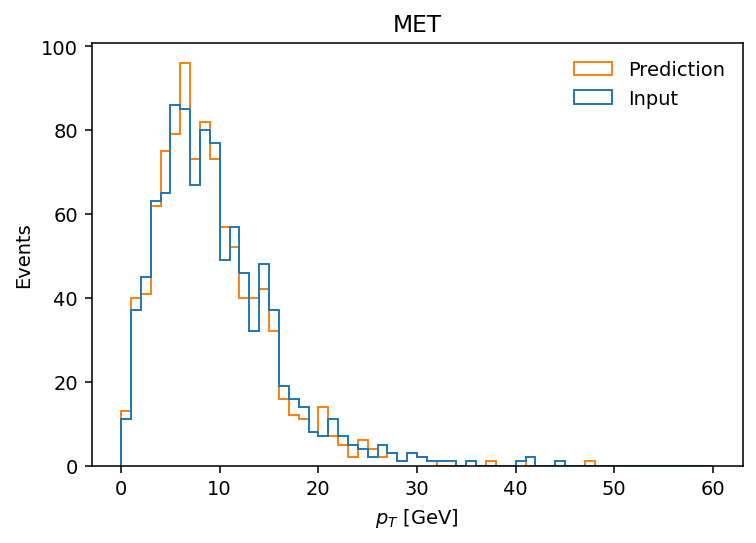

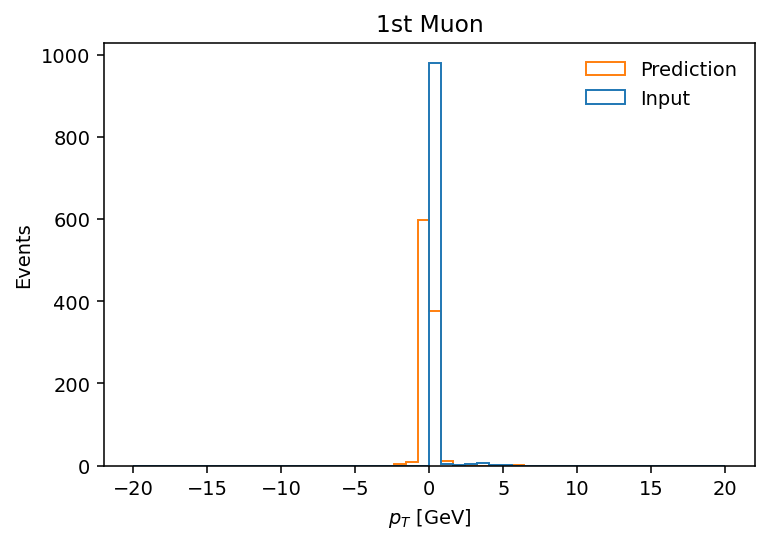

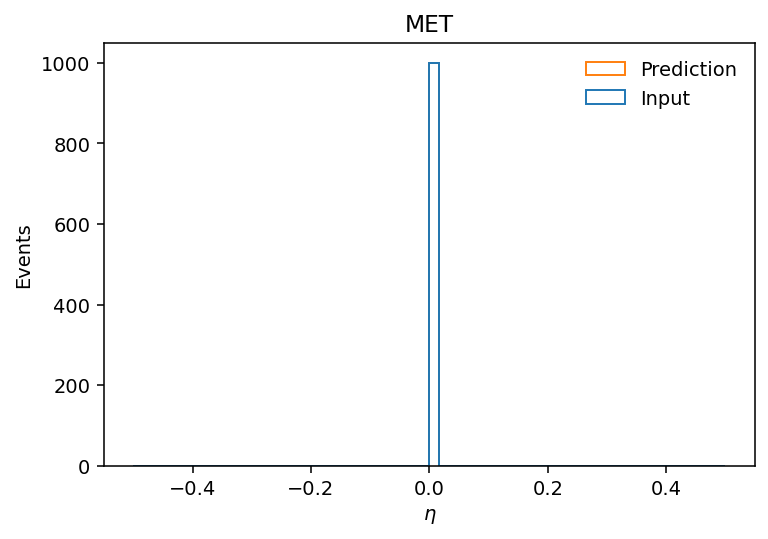

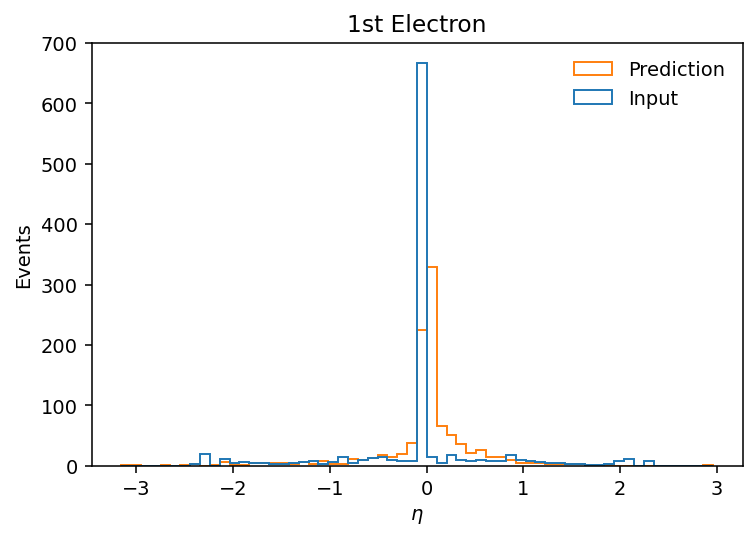

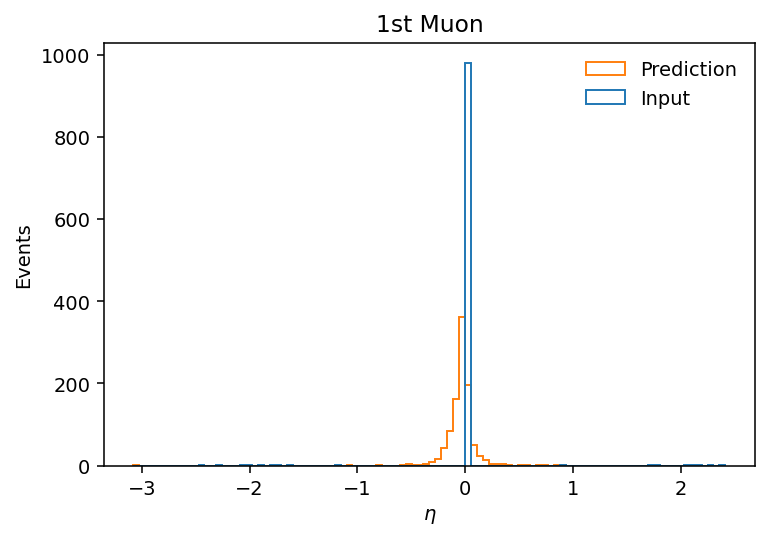

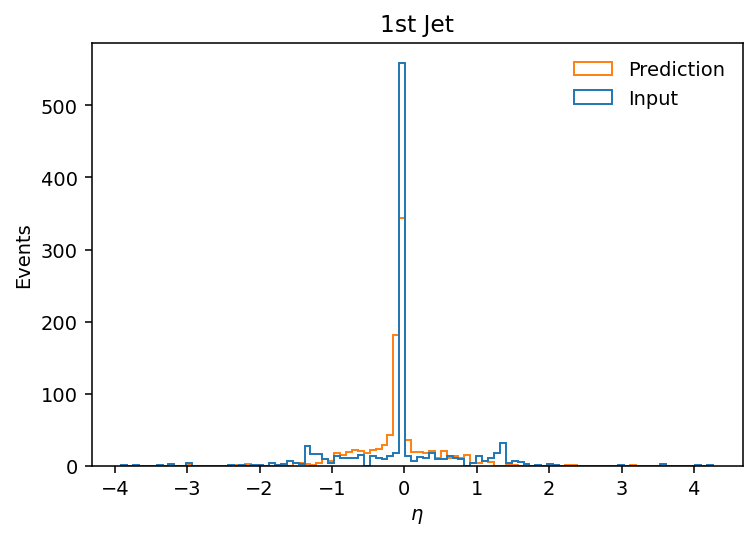

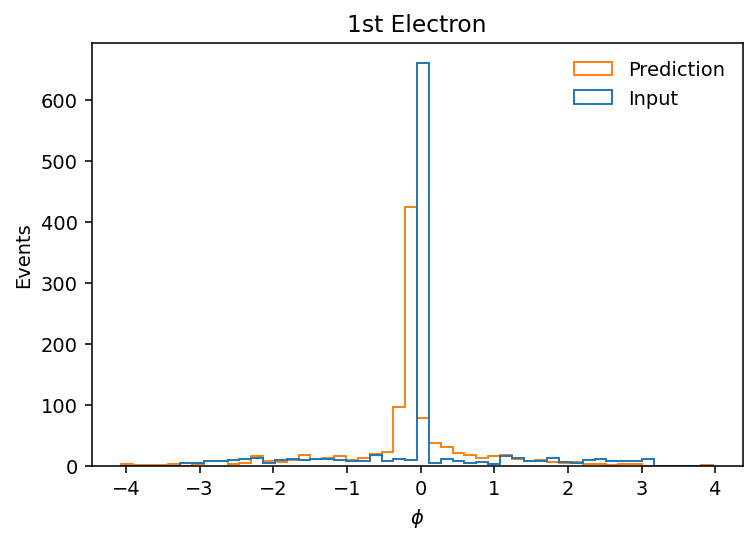

In [34]:
decoded_data = output.reshape(output.shape[0], 19,3)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 19,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Met Pt plot
plt.figure()
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=60,histtype='step',range = (0,60), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('MET')

#Electron Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,1,0],decoded_data[:,1,0]],bins=50,histtype='step',range = (0,40), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Electron')

#Muon Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,5,0],decoded_data[:,5,0]],bins=50,histtype='step',range = (-20,20), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Muon')

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,9,0],decoded_data[:,9,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

#Met eta plot
plt.figure()
plt.hist([data_valid_reshaped[:,0,1],decoded_data[:,0,1]],bins=60,histtype='step', label = ['Input','Prediction'])
plt.xlabel(r"$\eta$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('MET')

#Electron eta plot
plt.figure()
plt.hist([data_valid_reshaped[:,1,1],decoded_data[:,1,1]],bins=60,histtype='step', label = ['Input','Prediction'])
plt.xlabel(r"$\eta$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Electron')

#Muon eta plot
plt.figure()
plt.hist([data_valid_reshaped[:,5,1],decoded_data[:,5,1]],bins=100,histtype='step', label = ['Input','Prediction'])
plt.xlabel(r"$\eta$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Muon')

#Jet eta plot
plt.figure()
plt.hist([data_valid_reshaped[:,9,1],decoded_data[:,9,1]],bins=100,histtype='step', label = ['Input','Prediction'])
plt.xlabel(r"$\eta$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

#Met phi plot
plt.figure()
plt.hist([data_valid_reshaped[:,0,2],decoded_data[:,0,2]],bins=50,histtype='step', label = ['Input','Prediction'])
plt.xlabel(r"$\phi$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('MET')

#Electron phi plot
plt.figure()
plt.hist([data_valid_reshaped[:,1,2],decoded_data[:,1,2]],bins=50,histtype='step',label = ['Input','Prediction'])
plt.xlabel(r"$\phi$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Electron')

#Muon phi plot
plt.figure()
plt.hist([data_valid_reshaped[:,5,2],decoded_data[:,5,2]],bins=100,histtype='step', label = ['Input','Prediction'])
plt.xlabel(r"$\phi$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Muon')

#Jet phi plot
plt.figure()
plt.hist([data_valid_reshaped[:,9,2],decoded_data[:,9,2]],bins=80,histtype='step',label = ['Input','Prediction'])
plt.xlabel(r"$\phi$")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')